In [17]:
from sagemaker import get_execution_role

role=get_execution_role()
bucket = 'dongaws'

In [18]:
%%time
import pickle, gzip, numpy, urllib.request, json

#urllib.request.urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz','mnist.pkl.gz')

with gzip.open('mnist.pkl.gz') as f:
    train_set,valid_set,test_set=pickle.load(f,encoding='latin1')

CPU times: user 748 ms, sys: 265 ms, total: 1.01 s
Wall time: 1.01 s


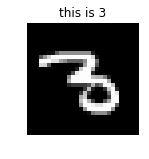

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(2,10)

def show_img(img,caption='',subplot=None):
    if subplot==None:
        _,subplot = plt.subplots(1,1)
    img=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(img,cmap='gray')
    plt.title(caption)
show_img(train_set[0][30],'this is {}'.format(train_set[1][30]))

In [22]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))


kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location
               )


training data will be uploaded to: s3://dongaws/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://dongaws/kmeans_highlevel_example/output


In [23]:
%%time
kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-11-25-00-28-23-779


2018-11-25 00:28:23 Starting - Starting the training job...
2018-11-25 00:28:35 Starting - Launching requested ML instances......
2018-11-25 00:29:39 Starting - Preparing the instances for training.........
2018-11-25 00:31:20 Downloading - Downloading input data
2018-11-25 00:31:20 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[11/25/2018 00:31:22 INFO 140293156546368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'm

Docker entrypoint called with argument(s): train
[11/25/2018 00:31:22 INFO 140375520319296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[11/25/2018 00:31:22 INFO 140375520319296] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'k': u'10', u'force_dense': u'True'}
[11/25/2018 00:31:22 INFO 140375520319296] Final configuration: {u'k': u'10', u'_tuning_o


2018-11-25 00:31:30 Uploading - Uploading generated training model
2018-11-25 00:31:30 Completed - Training job completed
Billable seconds: 53
CPU times: user 8.44 s, sys: 431 ms, total: 8.87 s
Wall time: 3min 53s


In [24]:
%%time

kmeans_predictor=kmeans.deploy(initial_instance_count=1,
                              instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-11-25-00-33-23-877
INFO:sagemaker:Creating endpoint with name kmeans-2018-11-25-00-28-23-779


---------------------------------------------------------------------------!CPU times: user 377 ms, sys: 30.2 ms, total: 407 ms
Wall time: 6min 20s


In [32]:
import boto3
import sagemaker
import json

input_key = 'kmeans_batch_example/input/valid-data.csv'
input_location = 's3://{}/{}'.format(bucket, input_key)
output_location = 's3://{}/kmeans_batch_example/output'.format(bucket)

### Convert the validation set numpy array to a csv file and upload to s3
numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
s3_client = boto3.client('s3')
s3_client.upload_file('valid-data.csv', bucket, input_key)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name='kmeans-2018-11-25-00-33-23-877',
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
    )
# To start a transform job:
transformer.transform(input_location, content_type='text/csv', split_type='Line')
# Then wait until transform job is completed
transformer.wait()

# To fetch validation result 
s3_client.download_file(bucket, 'kmeans_batch_example/output/valid-data.csv.out', 'valid-result')
with open('valid-result') as f:
    results = f.readlines()   
print("Sample transform result: {}".format(results[0]))


INFO:sagemaker:Creating transform job with name: Batch-Transform-2018-11-25-00-48-47-287


.......................................!
Sample transform result: {"closest_cluster":0.0,"distance_to_cluster":6.141941070556641}



In [35]:
result=kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 8.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.0553693771362305
    }
  }
}
]


In [37]:
%%time

results = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in results]

CPU times: user 31.4 ms, sys: 3.2 ms, total: 34.6 ms
Wall time: 225 ms





Cluster0


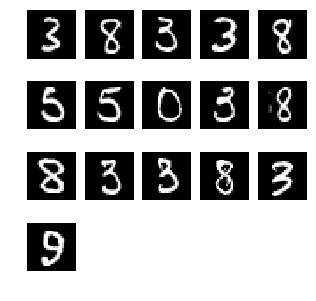




Cluster1


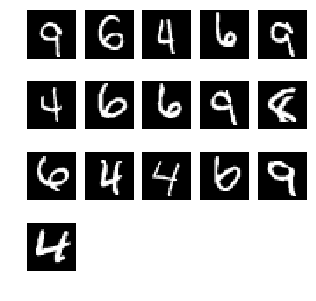




Cluster2


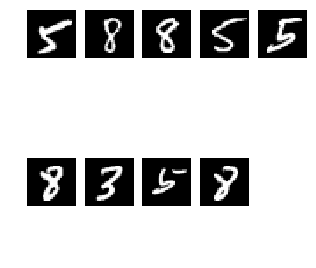




Cluster3


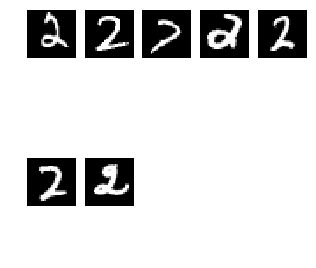




Cluster4


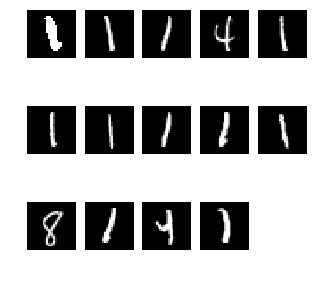




Cluster5


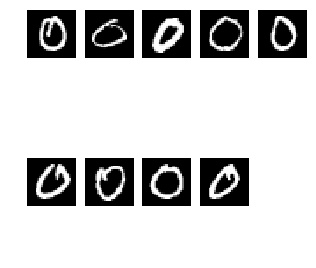




Cluster6


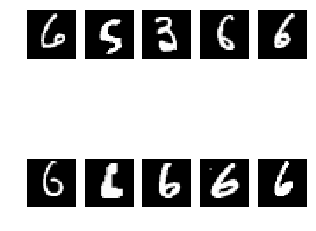




Cluster7


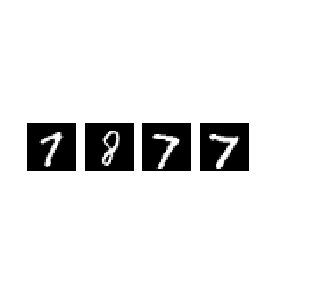




Cluster8


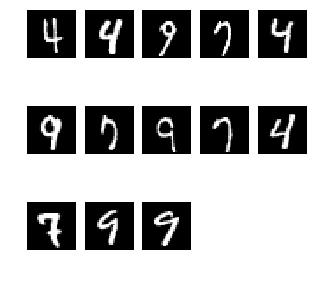




Cluster9


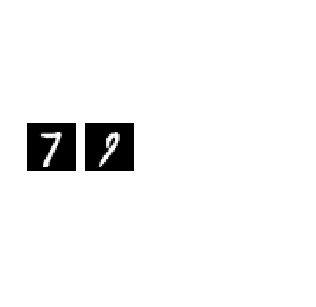

In [45]:
for cluster in range(10):
    print('\n\n\nCluster{}'.format(int(cluster)))
    digits = [img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster]
    height = ((len(digits)-1)//5)+1
    width = 5
    plt.rcParams["figure.figsize"] = (5,5)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_img(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [38]:
help(zip)

Help on class zip in module builtins:

class zip(object)
 |  zip(iter1 [,iter2 [...]]) --> zip object
 |  
 |  Return a zip object whose .__next__() method returns a tuple where
 |  the i-th element comes from the i-th iterable argument.  The .__next__()
 |  method continues until the shortest iterable in the argument sequence
 |  is exhausted and then it raises StopIteration.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.

